In [1]:
import libraries.utils as utils
from libraries.NeuralStates import *
import libraries.tfim_functions as tfim_functions
import libraries.training as training
from libraries import lib
import qutip as qt
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
N = 5
layers = []
layers.append(nn.Linear(N, 32))
for _ in range(2):
    layers.append(nn.Linear(32, 32))
    layers.append(nn.SELU())
layers.append(nn.Linear(32, 2))
mlp_model = nn.Sequential(*layers)

In [3]:
input = utils.generate_input_torch(N)
model_state = training.model_to_ground_state(N, mlp_model, utils.log_amp_phase)
prob_amps = np.abs(np.squeeze(model_state.full()) ** 2)
xs = np.arange(2 ** N)

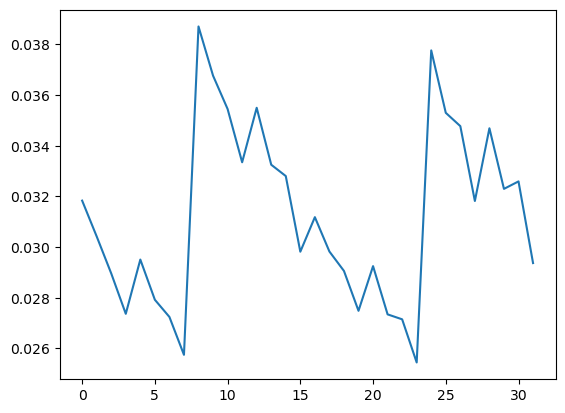

In [4]:
plt.plot(xs, prob_amps)
plt.show()

In [5]:
chains = 10
model_MH = MHNeuralState(N, mlp_model, utils.log_amp_phase, 
                         "doesn't matter", torch.zeros(chains, dtype = torch.long), 10000, 
                         burnin = 50, lag = 5, chains = chains)

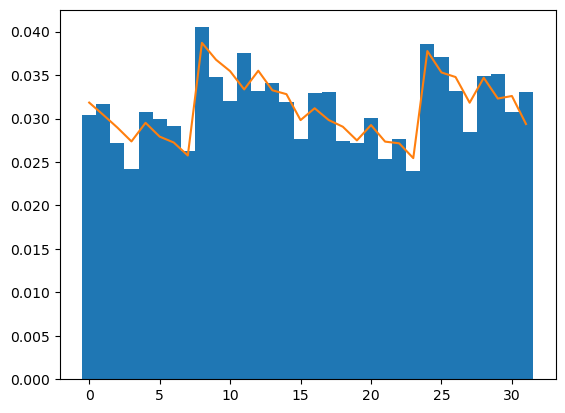

In [6]:
hist = plt.hist(model_MH.list, density = True, bins = [-0.5 + n for n in range(2 ** N + 1)])
plt.plot(xs, prob_amps)
plt.show()

In [7]:
def error(true_prob_amps, mh_state: MHNeuralState):
    total = 0
    for x in range(2 ** mh_state.N):
        total += abs(mh_state.distribution.get(x, 0) / mh_state.samples - true_prob_amps[x]) ** 2
    return np.sqrt(total / (2 ** mh_state.N))
def rmse(true_prob_amps, mh_state: MHNeuralState):
    return np.sqrt(np.mean([(true_prob_amps[x] - mh_state.distribution.get(x, 0) / mh_state.samples) ** 2 for x in range(2 ** mh_state.N)]))

In [8]:
num_samples = np.array([100, 500, 1000, 5000, 10000, 25000, 50000, 100000])
chains = 50
errors = []
for num in num_samples:
    model_MH = MHNeuralState(N, mlp_model, utils.log_amp_phase, 
                            "doesn't matter", torch.zeros(chains, dtype = torch.long), num, 
                            burnin = 50, lag = 5, chains = chains)
    errors.append(rmse(prob_amps, model_MH))
errors = np.array(errors)


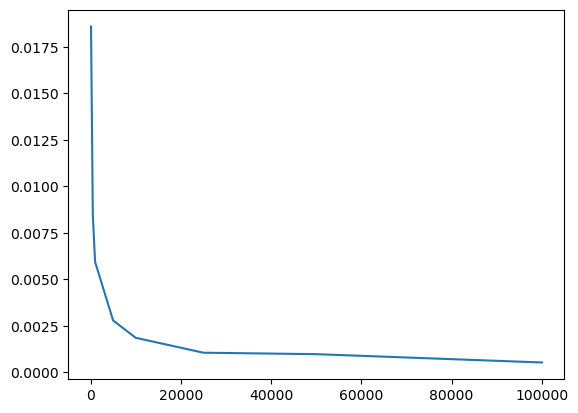

In [9]:
plt.plot(num_samples, errors)
plt.show()

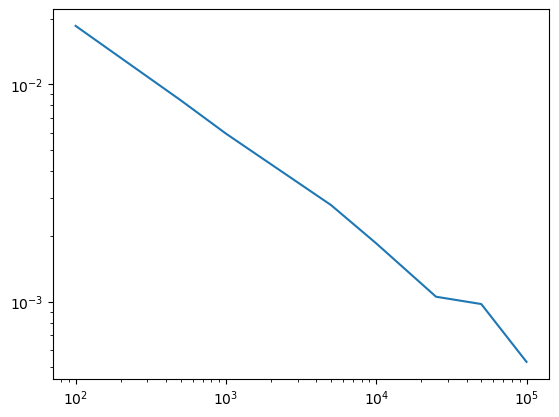

In [10]:
plt.loglog(num_samples, errors)
plt.show()

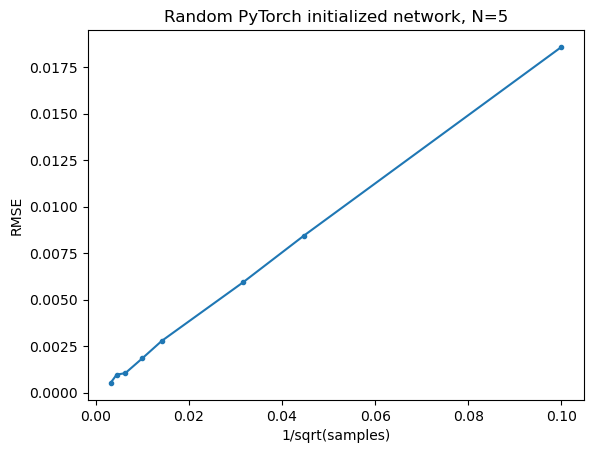

In [11]:
plt.plot(1/ np.sqrt(num_samples), errors, marker='.') # this is correct relation (should be linear)
plt.xlabel('1/sqrt(samples)')
plt.ylabel('RMSE')
plt.title('Random PyTorch initialized network, N=5')
plt.show()

In [12]:
stats.linregress(1/np.sqrt(num_samples), errors)

LinregressResult(slope=np.float64(0.18608522629873245), intercept=np.float64(3.3442644408960935e-05), rvalue=np.float64(0.999860575184951), pvalue=np.float64(6.775086200402691e-12), stderr=np.float64(0.0012687227380815498), intercept_stderr=np.float64(5.186655865354524e-05))

In [13]:
1/np.sqrt(num_samples)

array([0.1       , 0.04472136, 0.03162278, 0.01414214, 0.01      ,
       0.00632456, 0.00447214, 0.00316228])

In [14]:
np.floor((1/np.linspace(0.001, 0.1, 20)) ** 2).astype(int)

array([1000000,   25926,    7666,    3615,    2096,    1366,     960,
           712,     548,     435,     354,     294,     247,     211,
           182,     159,     140,     124,     111,     100])

In [15]:
spaced_samples = np.floor((1/np.linspace(0.001, 0.1, 20)) ** 2).astype(int)
chains = 200
spaced_errors = []
for num in spaced_samples:
    model_MH = MHNeuralState(N, mlp_model, utils.log_amp_phase, 
                            "doesn't matter", torch.zeros(chains, dtype = torch.long), num, 
                            burnin = 10*N, lag = N, chains = chains)
    spaced_errors.append(rmse(prob_amps, model_MH))
spaced_errors = np.array(spaced_errors)

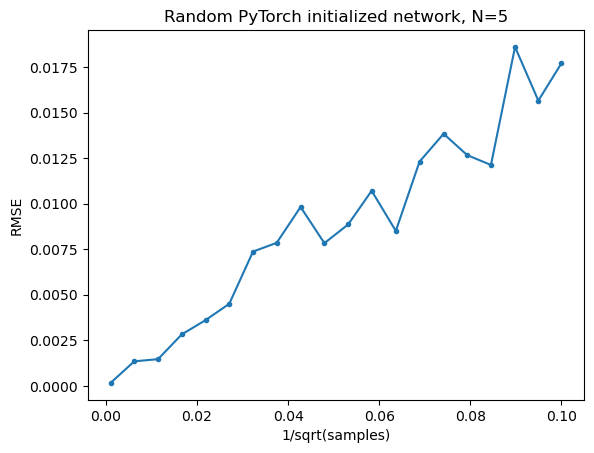

In [16]:
plt.plot(1/ np.sqrt(spaced_samples), spaced_errors, marker='.') # this is correct relation (should be linear)
plt.xlabel('1/sqrt(samples)')
plt.ylabel('RMSE')
plt.title('Random PyTorch initialized network, N=5')
plt.show()

In [17]:
stats.linregress(1/np.sqrt(spaced_samples), spaced_errors)

LinregressResult(slope=np.float64(0.17004666106022923), intercept=np.float64(0.00029189252827546003), rvalue=np.float64(0.9668701253885785), pvalue=np.float64(4.049152702041711e-12), stderr=np.float64(0.010581846388515033), intercept_stderr=np.float64(0.0006226226147647998))

In [18]:
def amp_phase(nn_output):
    return nn_output[:, 0] * torch.exp(1.j * 2 * np.pi * nn_output[:, 1])

In [19]:
# layers = []
# layers.append(nn.Linear(N, 32))
# for _ in range(2):
#     layers.append(nn.Linear(32, 32))
#     layers.append(nn.SELU())
# layers.append(nn.Linear(32, 2))
# mlp_model = nn.Sequential(*layers) # for some reason this nans?

mlp_model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)

input = utils.generate_input_torch(N)
vars = (N, 1, 1)
loss_fn = lib.TFIM_expectation_from_torch
epochs = []
loss_data = []
optimizer = torch.optim.SGD(mlp_model.parameters(), lr = 2)
for epoch in range(1000):
    y_pred = mlp_model(input)
    loss = loss_fn(y_pred, vars, amp_phase) # amp phase also seems to produce more symmetric results idk anymore
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [20]:
[n for n in mlp_model.parameters()]

[Parameter containing:
 tensor([[-0.2991, -0.3023, -0.5333, -0.2894, -0.0503],
         [-0.3295,  0.0746, -1.9777,  1.6233, -1.5920],
         [-0.0559, -0.3127, -0.2420,  0.0174,  0.2121],
         [-0.5185, -0.2561,  0.8331,  1.0042,  0.2548],
         [-1.1475,  0.6699, -0.1210, -1.2389, -0.2739],
         [ 0.2176, -0.3741, -0.3688, -0.5623, -0.5778],
         [ 0.9112,  2.0726,  1.9907,  0.7344, -0.0761],
         [ 0.6484,  1.6329,  1.6519,  0.7585,  0.1410],
         [ 0.3235, -0.9435, -0.9754,  1.0028, -1.5454],
         [-1.0448, -1.9441, -1.5925, -0.3698, -0.0608],
         [-0.3347, -0.5266, -0.4870,  0.1024, -0.2205],
         [-0.4243, -0.2656,  0.2615,  0.2271,  0.0769],
         [ 0.7777,  0.2127, -0.0398,  0.6246, -0.3761],
         [-1.0392, -1.2043,  1.7134, -0.8719, -0.3773],
         [ 0.7986,  0.5995,  0.0757, -0.3456,  0.3152],
         [ 1.7449, -1.3664,  1.5534,  0.4083, -0.4826],
         [ 1.0472,  0.2679,  0.2259,  0.9135,  1.4254],
         [-0.1802, -0.374

In [21]:
loss_fn(mlp_model(input), vars, amp_phase)

tensor(-6.4689, grad_fn=<DivBackward0>)

In [22]:
tfim_functions.TFIM_hamiltonian(N, 1, 1).eigenstates()[0][0]

np.float64(-6.472135954999574)

In [23]:
model_gs = training.model_to_ground_state(N, mlp_model, amp_phase)
gs_prob_amps = np.abs(np.squeeze(model_gs.full()) ** 2)

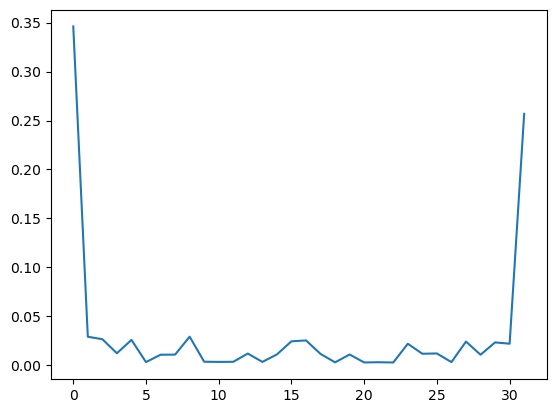

In [24]:
plt.plot(xs, gs_prob_amps)
plt.show()

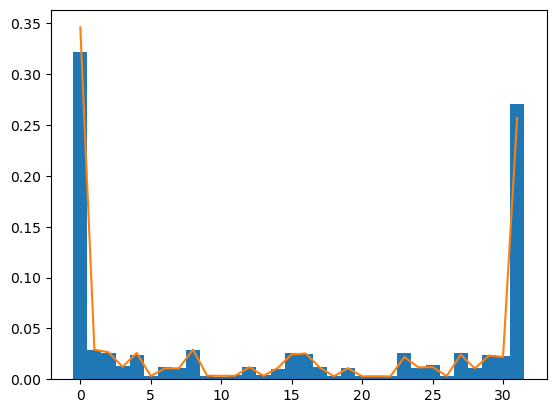

In [25]:
chains = 10
model_MH = MHNeuralState(N, mlp_model, amp_phase, 
                         "doesn't matter", torch.zeros(chains, dtype = torch.long), 10000, 
                         burnin = 50, lag = 5, chains = chains)
hist = plt.hist(model_MH.list, density = True, bins = [-0.5 + n for n in range(2 ** N + 1)])
plt.plot(xs, gs_prob_amps)
plt.show()

In [26]:
num_samples = np.array([100, 500, 1000, 5000, 10000, 25000, 50000, 100000])
chains = 50
gs_errors = []
for num in num_samples:
    model_MH = MHNeuralState(N, mlp_model, amp_phase, 
                            "doesn't matter", torch.zeros(chains, dtype = torch.long), num, 
                            burnin = 50, lag = 5, chains = chains)
    gs_errors.append(rmse(gs_prob_amps, model_MH))
gs_errors = np.array(gs_errors)


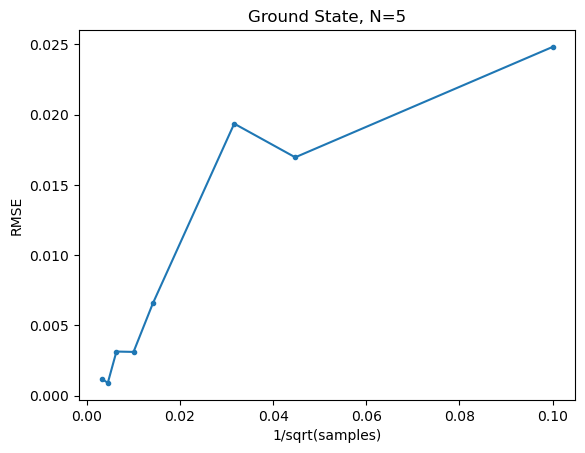

In [27]:
plt.plot(1/ np.sqrt(num_samples), gs_errors, marker='.') # this is correct relation (should be linear)
plt.xlabel('1/sqrt(samples)')
plt.ylabel('RMSE')
plt.title('Ground State, N=5')
plt.show()

In [28]:
stats.linregress(1/np.sqrt(num_samples), gs_errors)

LinregressResult(slope=np.float64(0.2577459581915317), intercept=np.float64(0.0025979055092026325), rvalue=np.float64(0.9040482914427105), pvalue=np.float64(0.0020526214562279735), stderr=np.float64(0.04974964022647587), intercept_stderr=np.float64(0.0020338112933177585))

In [29]:
spaced_samples = np.floor((1/np.linspace(0.001, 0.1, 20)) ** 2).astype(int)
chains = 200
gs_spaced_errors = []
for num in spaced_samples:
    model_MH = MHNeuralState(N, mlp_model, amp_phase, 
                            "doesn't matter", torch.zeros(chains, dtype = torch.long), num, 
                            burnin = 10*N, lag = N, chains = chains)
    gs_spaced_errors.append(rmse(gs_prob_amps, model_MH))
gs_spaced_errors = np.array(gs_spaced_errors)

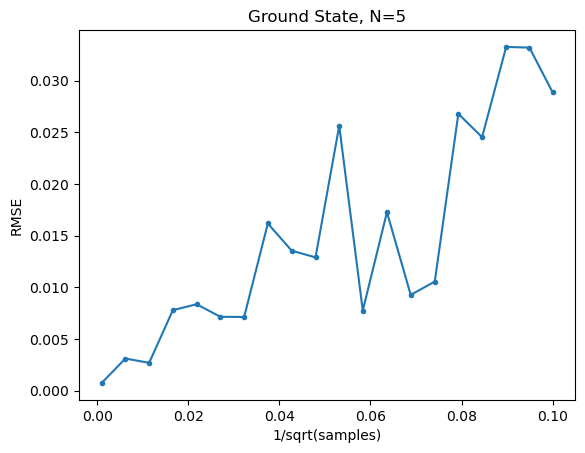

In [32]:
plt.plot(1/ np.sqrt(spaced_samples), gs_spaced_errors, marker='.') # this is correct relation (should be linear)
plt.xlabel('1/sqrt(samples)')
plt.ylabel('RMSE')
plt.title('Ground State, N=5')
plt.show()

In [31]:
stats.linregress(1/np.sqrt(spaced_samples), gs_spaced_errors)

LinregressResult(slope=np.float64(0.2839078192338758), intercept=np.float64(0.00047296395924013857), rvalue=np.float64(0.8475923415981921), pvalue=np.float64(2.3902218607310425e-06), stderr=np.float64(0.04189484126319847), intercept_stderr=np.float64(0.0024650400936418585))